In [1]:
import time
import copy

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data.dataset import random_split
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import numpy as np

import matplotlib.pyplot as plt

import bitsandbytes as bnb

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
num_epochs = 5
num_classes = 10
batch_size = 128
learning_rate = 0.001

In [4]:
torch.manual_seed(0)

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, transform=transform)

# Before
print('Train data set:', len(train_dataset))
print('Test data set:', len(test_dataset))

# Random split
train_set_size = int(len(train_dataset) * 0.8)
indices = list(range(train_set_size))
split = int(np.floor(.2 * train_set_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler =  SequentialSampler(val_indices)
   

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=train_sampler,
                                           batch_size=batch_size,
                                           )

valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=valid_sampler,
                                           batch_size=batch_size,
                                           )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False)

Train data set: 60000
Test data set: 10000


In [5]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.non_linearity1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.non_linearity2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(8*8*32, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.max_pool1(x)
        x = self.non_linearity1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.max_pool2(x)
        x = self.non_linearity2(x)

        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [6]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # scale gradint and perform backward pass
                        #loss.backward()
                        scaler.scale(loss).backward()
                        
                        # before gradient clipping the optimizer parameters must be unscaled.
                        scaler.unscale_(optimizer)
                        
                        # perform optimization step
                        #optimizer.step()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)
                        scaler.step(optimizer)
                        scaler.update()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            #nsamples = dataloaders[phase].dataset.data.shape[0]
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.5f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
Total number of parameters = 25386
Epoch 0/4
----------
train Loss: 0.2095 Acc: 0.93823
val Loss: 0.0958 Acc: 0.97073

Epoch 1/4
----------
train Loss: 0.0617 Acc: 0.98060
val Loss: 0.0648 Acc: 0.98115

Epoch 2/4
----------
train Loss: 0.0477 Acc: 0.98573
val Loss: 0.0614 Acc: 0.98229

Epoch 3/4
----------
train Loss: 0.0349 Acc: 0.98932
val Loss: 0.0563 Acc: 0

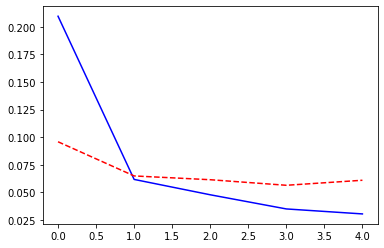

In [7]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = ConvNet(num_classes).to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

optimizer = bnb.optim.Adam8bit(model.parameters(), lr=0.001)

print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=5, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [8]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.98380 


ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
Total number of parameters = 25386
Epoch 0/19
----------
train Loss: 0.1690 Acc: 0.94753
val Loss: 0.0913 Acc: 0.97052

Epoch 1/19
----------
train Loss: 0.0594 Acc: 0.98109
val Loss: 0.0609 Acc: 0.98156

Epoch 2/19
----------
train Loss: 0.0467 Acc: 0.98487
val Loss: 0.0550 Acc: 0.98313

Epoch 3/19
----------
train Loss: 0.0365 Acc: 0.98862
val Loss: 0.0557 Ac

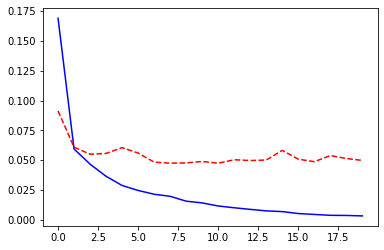

In [ ]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = ConvNet(num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.98930 


ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
Total number of parameters = 25386
Epoch 0/19
----------
train Loss: 0.2217 Acc: 0.93875
val Loss: 0.0991 Acc: 0.96958

Epoch 1/19
----------
train Loss: 0.0631 Acc: 0.98086
val Loss: 0.0677 Acc: 0.97969

Epoch 2/19
----------
train Loss: 0.0456 Acc: 0.98586
val Loss: 0.0576 Acc: 0.98135

Epoch 3/19
----------
train Loss: 0.0372 Acc: 0.98849
val Loss: 0.0568 Ac

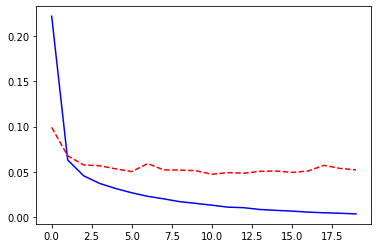

In [ ]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = ConvNet(num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9, nesterov=True)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.98690 


ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
Total number of parameters = 25386
Epoch 0/19
----------
train Loss: 0.4818 Acc: 0.89052
val Loss: 0.2616 Acc: 0.93823

Epoch 1/19
----------
train Loss: 0.2218 Acc: 0.94549
val Loss: 0.1969 Acc: 0.95292

Epoch 2/19
----------
train Loss: 0.1754 Acc: 0.95573
val Loss: 0.1662 Acc: 0.95927

Epoch 3/19
----------
train Loss: 0.1512 Acc: 0.96102
val Loss: 0.1495 Ac

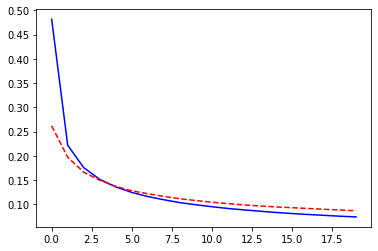

In [ ]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = ConvNet(num_classes).to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.97980 


ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
Total number of parameters = 25386
Epoch 0/19
----------
train Loss: 2.3542 Acc: 0.17781
val Loss: 2.1439 Acc: 0.27667

Epoch 1/19
----------
train Loss: 1.9828 Acc: 0.39513
val Loss: 1.8227 Acc: 0.52156

Epoch 2/19
----------
train Loss: 1.6947 Acc: 0.58982
val Loss: 1.5546 Acc: 0.66531

Epoch 3/19
----------
train Loss: 1.4494 Acc: 0.69487
val Loss: 1.3287 Ac

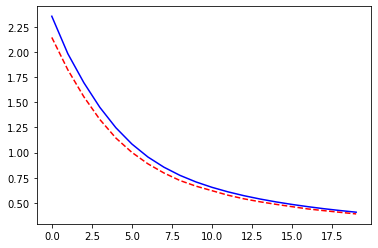

In [ ]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = ConvNet(num_classes).to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.91770 


ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
Total number of parameters = 25386
Epoch 0/19
----------
train Loss: 0.3198 Acc: 0.92784
val Loss: 0.0972 Acc: 0.97083

Epoch 1/19
----------
train Loss: 0.0753 Acc: 0.97674
val Loss: 0.0729 Acc: 0.97948

Epoch 2/19
----------
train Loss: 0.0544 Acc: 0.98307
val Loss: 0.0552 Acc: 0.98396

Epoch 3/19
----------
train Loss: 0.0429 Acc: 0.98656
val Loss: 0.0586 Ac

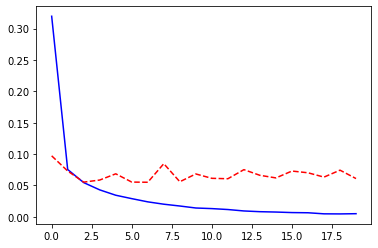

In [ ]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = ConvNet(num_classes).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.98860 


ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
Total number of parameters = 25386
Epoch 0/19
----------
train Loss: 0.2083 Acc: 0.94026
val Loss: 0.0829 Acc: 0.97573

Epoch 1/19
----------
train Loss: 0.0625 Acc: 0.98112
val Loss: 0.0647 Acc: 0.98010

Epoch 2/19
----------
train Loss: 0.0453 Acc: 0.98602
val Loss: 0.0596 Acc: 0.98156

Epoch 3/19
----------
train Loss: 0.0363 Acc: 0.98878
val Loss: 0.0714 Ac

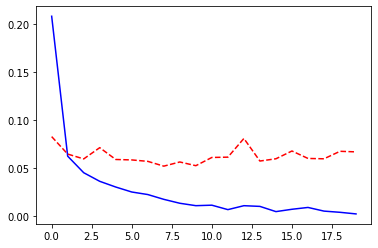

In [ ]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = ConvNet(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.98590 
